In [2]:
!pwd

/mnt/home/eneubeck/GADME


In [3]:
# Importe 
# dauert länger

import json
import logging
import os

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import transformers
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from omegaconf import DictConfig
from PIL import Image
from pytorch_lightning import Callback
from torchaudio.transforms import MelScale, Spectrogram

from birdset.datamodule.birdset_datamodule import BirdSetDataModule

from hydra import compose, initialize
from hydra.utils import instantiate
from birdset.train import train

In [4]:
# dauert länger
# !nvidia-smi

In [5]:
# print(torch.cuda.is_available())

# 1- Loading the datasets and the models

## 1.1 Die Daten

### 1.1.1 Hydra

Um die Daten in der gleichen Reihenfolge zu laden
also z.B. train_batch_eff_1[x] == train_batch_ast_1[x]
werden vor der Ausführung von hydra die beiden yamls angepasst:
GADME/configs/experiment/local/HSN/efficientnet.yaml
GADME/configs/experiment/local/HSN/ast_HSN.yaml

efficientnet.yaml
Z. 56       shuffle: False

ast_HSN.yaml
Z. 53 eventlimit: 3  # für XAI ipynb
ab Z. 55:   bei train val und test: batch_size: 64, shuffle: False, num_workers: 32, und nur bei train drop_last: True

zur target_width in configs/datamodule/transforms/preprocessing/resizer.yaml:
efficientnet benötigt beim Training target_width = Null
ast benötigt beim Training (je nach hop_length etc.) target_width = 1024

Hier vor hydra Test mit target_width = Null für beide Modelle
das funktioniert nicht, gibt bei output_train_batch_1_ast = ast_model(input_train_batch_ast_1)den Fehler:
RuntimeError: The size of tensor a (590) must match the size of tensor b (1214) at non-singleton dimension 1

Zweiter Test mit target_width = 1024 für beide Modelle, 
funktioniert soweit

In [6]:
# Hydra efficientnet

with initialize(version_base="1.3", config_path="configs/"):
    cfg_eff = compose(config_name="train.yaml", return_hydra_config=True, overrides=["experiment=local/HSN/efficientnet.yaml"])

cfg_eff.logger.wandb.mode = "offline"
cfg_eff.paths.work_dir = '${hydra.runtime.cwd}'

In [7]:
# Hydra ast

with initialize(version_base="1.3", config_path="configs/"):
    cfg_ast = compose(config_name="train.yaml", return_hydra_config=True, overrides=["experiment=local/HSN/ast_HSN.yaml"])

cfg_ast.logger.wandb.mode = "offline"
cfg_ast.paths.work_dir = '${hydra.runtime.cwd}'

In [8]:
# Hydra w2v2

with initialize(version_base="1.3", config_path="configs/"):
# TODO: richtige yaml auswählen, in der yaml batch-size, shuffle einstellen 
    cfg_w2v2 = compose(config_name="train.yaml", return_hydra_config=True, overrides=["experiment=local/HSN/wav2vec2_2-xai-data.yaml"])

cfg_w2v2.logger.wandb.mode = "offline"
cfg_w2v2.paths.work_dir = '${hydra.runtime.cwd}'

### 1.1.2 Datamodules and Train-/ Val- and Test-Loaders

In [9]:
# Creating the BirdSet Datamodules
datamodule_eff = instantiate(cfg_eff.datamodule)
datamodule_ast = instantiate(cfg_ast.datamodule)
datamodule_w2v2 = instantiate(cfg_w2v2.datamodule)

In [1]:
# Prepare Data
# dauert
datamodule_eff.prepare_data()
datamodule_ast.prepare_data()
print("done")

NameError: name 'datamodule_eff' is not defined

In [10]:
# Prepare Data
# dauert
datamodule_w2v2.prepare_data()
print("done")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Setting num_proc from 3 back to 1 for the test_5s split to disable multiprocessing as it only contains one shard.


Generating test_5s split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/5460 [00:00<?, ? examples/s]

Map:   0%|          | 0/38170 [00:00<?, ? examples/s]

Processing labels: 100%|██████████| 21/21 [00:02<00:00, 10.34it/s]


Map:   0%|          | 0/14723 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11778 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2945 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/38170 [00:00<?, ? examples/s]

Processing labels: 100%|██████████| 21/21 [00:02<00:00, 10.42it/s]


Map:   0%|          | 0/14723 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11778 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2945 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5460 [00:00<?, ? examples/s]

Map:   0%|          | 0/38170 [00:00<?, ? examples/s]

Processing labels: 100%|██████████| 21/21 [00:01<00:00, 12.21it/s]


Map:   0%|          | 0/18256 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/14604 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3652 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

done


In [11]:
"""
#nur w2v2
# Prepare Data
# dauert

datamodule_w2v2.prepare_data()
print("done")
"""

'\n#nur w2v2\n# Prepare Data\n# dauert\n\ndatamodule_w2v2.prepare_data()\nprint("done")\n'

In [12]:
# Setup for Training Phase

# Setup the datamodule for the training phase
datamodule_eff.setup(stage="fit")
datamodule_ast.setup(stage="fit")
datamodule_w2v2.setup(stage="fit")

# Retrieve the training and validation dataloaders
train_loader_eff = datamodule_eff.train_dataloader()
validation_loader_eff = datamodule_eff.val_dataloader()

train_loader_ast = datamodule_ast.train_dataloader()
validation_loader_ast = datamodule_ast.val_dataloader

train_loader_w2v2 = datamodule_w2v2.train_dataloader()
validation_loader_w2v2 = datamodule_w2v2.val_dataloader()

In [13]:
"""
#nur w2v2
# Setup for Training Phase

# Setup the datamodule for the training phase
datamodule_w2v2.setup(stage="fit")

# Retrieve the training and validation dataloaders

train_loader_w2v2 = datamodule_w2v2.train_dataloader()
validation_loader_w2v2 = datamodule_w2v2.val_dataloader()
"""

'\n#nur w2v2\n# Setup for Training Phase\n\n# Setup the datamodule for the training phase\ndatamodule_w2v2.setup(stage="fit")\n\n# Retrieve the training and validation dataloaders\n\ntrain_loader_w2v2 = datamodule_w2v2.train_dataloader()\nvalidation_loader_w2v2 = datamodule_w2v2.val_dataloader()\n'

In [14]:
# Datamodule Setup for Test Phase

# Setup the datamodule for the test phase
datamodule_eff.setup(stage="test")
datamodule_ast.setup(stage="test")
datamodule_w2v2.setup(stage="test")

# Retrieve the test dataloader
test_loader_eff = datamodule_eff.test_dataloader()
test_loader_ast = datamodule_ast.test_dataloader()
test_loader_w2v2 = datamodule_w2v2.test_dataloader()

In [15]:
"""
# nur w2v2
# Datamodule Setup for Test Phase

# Setup the datamodule for the test phase
datamodule_w2v2.setup(stage="test")

# Retrieve the test dataloader
test_loader_w2v2 = datamodule_w2v2.test_dataloader()
"""

'\n# nur w2v2\n# Datamodule Setup for Test Phase\n\n# Setup the datamodule for the test phase\ndatamodule_w2v2.setup(stage="test")\n\n# Retrieve the test dataloader\ntest_loader_w2v2 = datamodule_w2v2.test_dataloader()\n'

### 1.1.3 Daten aus dem Train- und Testloader holen und in Dateien speichern

In [16]:
def process_batch(dataloader, model_name, data_type, batch_index=1):
    base_path = f'/mnt/home/eneubeck/GADME/XAI/{model_name.lower()}_{data_type}_batch{batch_index}.pth'

    # Durchlaufen des Dataloaders, um den gewünschten Batch zu erhalten
    for i, batch in enumerate(dataloader, start=1):
        if i == batch_index:
            # Batch speichern
            torch.save(batch, base_path)

            # Schlüssel und Formen der Daten ausgeben
            print(f'{model_name} {data_type} batch{i}:', batch.keys(), batch["input_values"].shape, batch["labels"].shape)

            return batch

    return None  # Falls der Batch-Index nicht vorhanden ist

eff_train_batch1 = process_batch(train_loader_eff, 'eff', 'train', 1)
eff_train_batch2 = process_batch(train_loader_eff, 'eff', 'train', 2)
ast_train_batch1 = process_batch(train_loader_ast, 'AST', 'train', 1)
ast_train_batch2 = process_batch(train_loader_ast, 'AST', 'train', 2)
w2v2_train_batch1 = process_batch(train_loader_w2v2, 'w2v2', 'train', 1)
w2v2_train_batch2 = process_batch(train_loader_w2v2, 'w2v2', 'train', 2)

eff_test_batch1 = process_batch(test_loader_eff, 'eff', 'test', 1)
eff_test_batch2 = process_batch(test_loader_eff, 'eff', 'test', 2)
ast_test_batch1 = process_batch(test_loader_ast, 'AST', 'test', 1)
ast_test_batch2 = process_batch(test_loader_ast, 'AST', 'test', 2)
w2v2_test_batch1 = process_batch(test_loader_w2v2, 'w2v2', 'test', 1)
w2v2_test_batch2 = process_batch(test_loader_w2v2, 'w2v2', 'test', 2)

eff train batch1: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 128, 1024]) torch.Size([64, 21])
eff train batch2: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 128, 1024]) torch.Size([64, 21])
AST train batch1: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 128, 1024]) torch.Size([64, 21])
AST train batch2: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 128, 1024]) torch.Size([64, 21])
w2v2 train batch1: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 80000]) torch.Size([64, 21])
w2v2 train batch2: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 80000]) torch.Size([64, 21])
eff test batch1: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 128, 1024]) torch.Size([64, 21])
eff test batch2: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 128, 1024]) torch.Size([64, 21])
AST test batch1: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 128, 1024]) torch.Size([64, 21])
AST test batch2: dict_keys(['input_va

In [17]:
#nur w2v2
def process_batch(dataloader, model_name, data_type, batch_index=1):
    base_path = f'/mnt/home/eneubeck/GADME/XAI/{model_name.lower()}_{data_type}_batch{batch_index}.pth'

    # Durchlaufen des Dataloaders, um den gewünschten Batch zu erhalten
    for i, batch in enumerate(dataloader, start=1):
        if i == batch_index:
            # Batch speichern
            torch.save(batch, base_path)

            # Schlüssel und Formen der Daten ausgeben
            print(f'{model_name} {data_type} batch{i}:', batch.keys(), batch["input_values"].shape, batch["labels"].shape)

            return batch

    return None  # Falls der Batch-Index nicht vorhanden ist

w2v2_train_batch1 = process_batch(train_loader_w2v2, 'w2v2', 'train', 1)
w2v2_train_batch2 = process_batch(train_loader_w2v2, 'w2v2', 'train', 2)

w2v2_test_batch1 = process_batch(test_loader_w2v2, 'w2v2', 'test', 1)
w2v2_test_batch2 = process_batch(test_loader_w2v2, 'w2v2', 'test', 2)


w2v2 train batch1: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 80000]) torch.Size([64, 21])
w2v2 train batch2: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 80000]) torch.Size([64, 21])
w2v2 test batch1: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 80000]) torch.Size([64, 21])
w2v2 test batch2: dict_keys(['input_values', 'labels']) torch.Size([64, 1, 80000]) torch.Size([64, 21])


In [18]:
# Überprüfung: sind die test_batches bei eff und ast gleich? ja
# Wie viele no-label samples sind dabei? viele, aber nciht alle

batches = [
    ("eff_test_batch1", eff_test_batch1['labels']),
    ("ast_test_batch1", ast_test_batch1['labels']),
    ("w2v2_test_batch1", w2v2_test_batch1['labels']),
    ("eff_test_batch2", eff_test_batch2['labels']),
    ("ast_test_batch2", ast_test_batch2['labels']),
    ("w2v2_test_batch2", w2v2_test_batch2['labels'])
]

# Durchgehen jeder Batch-Bezeichnung und Labels
for batch_name, labels in batches:
    index_list = []  # Initialisiere die Liste für die aktuellen Labels

    # Durchgehen jedes Vektors in den Labels
    for label in labels:
        # Ermitteln der Indizes aller Einsen
        indices = (label == 1).nonzero(as_tuple=True)[0]
        # Umwandeln in ein Tupel
        index_list.append(tuple(indices.tolist()) if indices.numel() > 0 else ())

    # Ausgabe der Indizes für den aktuellen Batch
    print(f"{batch_name}: {index_list}")

eff_test_batch1: [(0,), (0,), (), (), (), (), (), (), (), (), (), (), (), (), (2,), (), (), (), (1,), (1, 2), (2,), (1, 2), (1, 2), (2,), (1, 2), (), (), (), (), (), (3,), (3,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (1, 3), (1, 2), (2,), (1, 2), (2,), (1,), (), (1,), (), (1,), (), (1,), (1,), (), (), (1,), (), (1, 2)]
ast_test_batch1: [(0,), (0,), (), (), (), (), (), (), (), (), (), (), (), (), (2,), (), (), (), (1,), (1, 2), (2,), (1, 2), (1, 2), (2,), (1, 2), (), (), (), (), (), (3,), (3,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (1, 3), (1, 2), (2,), (1, 2), (2,), (1,), (), (1,), (), (1,), (), (1,), (1,), (), (), (1,), (), (1, 2)]
w2v2_test_batch1: [(0,), (0,), (), (), (), (), (), (), (), (), (), (), (), (), (2,), (), (), (), (1,), (1, 2), (2,), (1, 2), (1, 2), (2,), (1, 2), (), (), (), (), (), (3,), (3,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (1, 3), (1, 2), (2,), (1, 2), (2,), (1,), (), (1,), (), (1,), (), (1,), (1,), (), (), (1,

### 1.1.4 Spektrogramm (nur in XAI-xai.ipynb)

In [19]:
# def 

def show_spectrogram(spektrum, sr, hop_length, n_fft, titel='Mel-Spektrogramm', cmap="viridis"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spektrum, 
                             y_axis='mel', sr=sample_rate, hop_length=hop_length, n_fft=n_fft,  
                             x_axis='time', cmap=cmap)
    plt.colorbar(format='%+2.0f dB')
    plt.title(titel)
    plt.tight_layout()
    plt.show()


n_fft = datamodule_eff.transforms.preprocessing.spectrogram_conversion.n_fft
hop_length = datamodule_eff.transforms.preprocessing.spectrogram_conversion.hop_length
sample_rate = datamodule_eff.transforms.preprocessing.melscale_conversion.sample_rate
n_mels = datamodule_eff.transforms.preprocessing.melscale_conversion.n_mels

In [20]:
sample_rate_w2v2 = datamodule_w2v2.transforms.preprocessing.melscale_conversion.sample_rate

### 1.1.5 Überprüfung der Daten Eff und AST

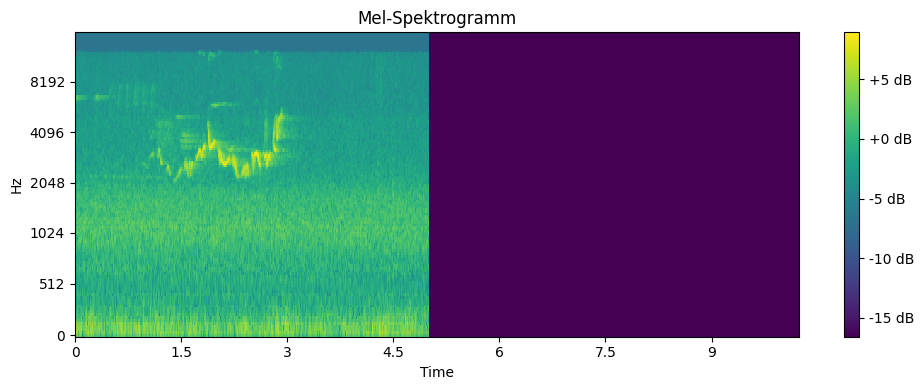

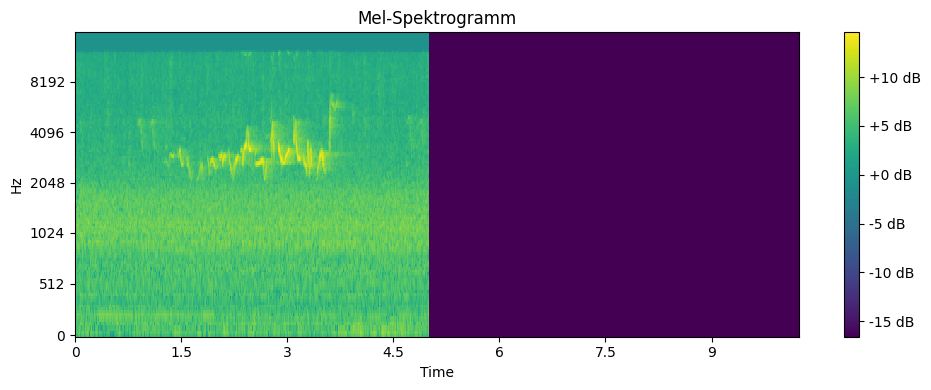

In [21]:
# Überprüfung train_batches: Sind die Samples von eff und ast an Stelle eff_train_batch1[x] / ast_train_batch1[x] gleich?
# Fazit: ja, aber durch unterschiedliche Vorverarbeitung unterscheiden sie sich z.T. erheblich
# ähnlich bei 0, 1, 2, 3, 4, 50
# sehr unterschiedlich bei 51

train_batch1_example_number = 4

model_batches = [
    ("EfficientNet", eff_train_batch1),
    ("AST", ast_train_batch1)
]

for model_name, batch in model_batches:
    example = batch["input_values"][train_batch1_example_number]
    example_np = example.numpy().squeeze()  # Umwandlung in Numpy-Array und Entfernen überflüssiger Dimensionen

    show_spectrogram(example_np, sr=sample_rate, hop_length=hop_length, n_fft=n_fft)

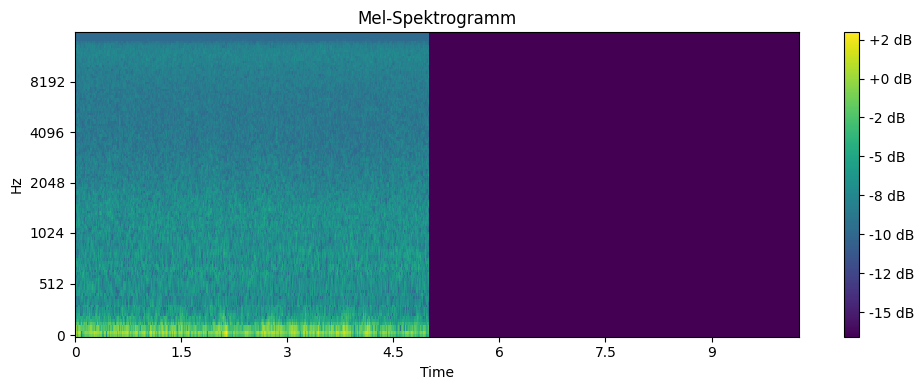

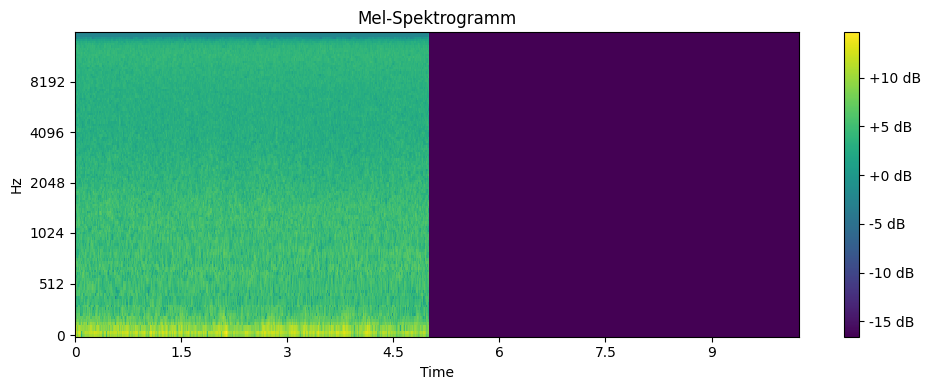

In [22]:
# Überprüfung test_batches: Sind die Samples von eff und ast an Stelle eff_test_batch1[x] / ast_test_batch1[x] gleich?
# Fazit: diejenigen, die ich kontrolliert habe sind ähnlich

# ähnlich bei 0, 1, 2, 50, 51, 63

test_batch1_example_number = 2

model_batches = [
    ("EfficientNet", eff_test_batch1),
    ("AST", ast_test_batch1)
]

for model_name, batch in model_batches:
    example = batch["input_values"][test_batch1_example_number]
    example_np = example.numpy().squeeze()  # Umwandlung in Numpy-Array und Entfernen überflüssiger Dimensionen

    show_spectrogram(example_np, sr=sample_rate, hop_length=hop_length, n_fft=n_fft)

### 1.1.6 Überprüfung eines Samples aus den Testdaten, um die baseline für Occlusion zu ermitteln

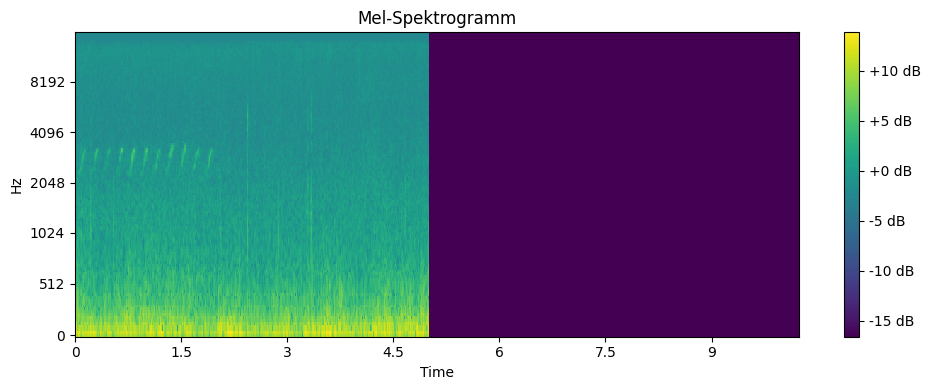

In [55]:
### Überprüfung eines Samples aus den Testdaten
# Sample from test_batch1

test_sample_id = 31

ast_test_batch1_sample = ast_test_batch1["input_values"][test_sample_id].unsqueeze(0)
ast_test_batch1_sample_np = ast_test_batch1_sample.numpy().squeeze()

# Visualisierung
show_spectrogram(ast_test_batch1_sample_np, sr=sample_rate, hop_length=hop_length, n_fft=n_fft)

# Berechne den Startindex für das letzte Drittel
start_index = 2 * (ast_test_batch1_sample.size(3) // 2)

# Extrahiere das letzte Drittel des Spektrogramms
last_third = ast_test_batch1_sample[:, :, :, start_index:]

# Überprüfe, ob alle Werte -16.5752 sind
all_equal = torch.all(last_third == -16.57518196105957)
for value in last_third.flatten():
    if value != -16.57518196105957:
        all_equal = False
        print(f"Nicht übereinstimmender Wert gefunden: {value.item()}")

print(f"Alle Werte im letzten Drittel sind -16.57518196105957: {all_equal}")


### 1.1.7 audio_config.json

In [24]:
# Werte für das Spektrogramm aus dem Datamodule in der audio_config.json Konfigurationsdatei speichern

# Werte, die gespeichert werden sollen
audio_config = {
    "n_fft": datamodule_eff.transforms.preprocessing.spectrogram_conversion.n_fft,
    "hop_length": datamodule_eff.transforms.preprocessing.spectrogram_conversion.hop_length,
    "sample_rate": datamodule_eff.transforms.preprocessing.melscale_conversion.sample_rate,
    "n_mels": datamodule_eff.transforms.preprocessing.melscale_conversion.n_mels,
    "target_width_eff": datamodule_eff.transforms.preprocessing.resizer.target_width,
    "target_width_ast": datamodule_ast.transforms.preprocessing.resizer.target_width,
    #"sampling_rate": datamodule_w2v2.module.network.sampling_rate
}

# Speichern der Daten in einer JSON-Datei
with open('/mnt/home/eneubeck/GADME/XAI/audio_config.json', 'w') as f:
    json.dump(audio_config, f)

print("Konfigurationsdaten gespeichert!")

Konfigurationsdaten gespeichert!


In [25]:
# target_width
datamodules = [datamodule_eff, datamodule_ast]

for datamodule in datamodules:
    target_width = datamodule.transforms.preprocessing.resizer.target_width
    print(f"{datamodule} target width: {target_width}")

<birdset.datamodule.birdset_datamodule.BirdSetDataModule object at 0x7f176d74d420> target width: 1024
<birdset.datamodule.birdset_datamodule.BirdSetDataModule object at 0x7f19745b03a0> target width: 1024


## 1.2 Mapping of Labels to eBird Codes (in XAI-only-xai)

## 1.3 Die Modelle

In [26]:
# EfficientNet Modell

# EfficientNetClassifier importieren
from birdset.modules.models.efficientnet import EfficientNetClassifier

# Definition der Parameter
num_classes = 21 # The number of classes for the output layer
num_channels = 1  # The number of input channels  # 1 für Für Graustufenbildern 
checkpoint_path = "logs/train/runs/HSN/efficientnet/2024-04-25_140516/callback_checkpoints/efficientnet_HSN_32.ckpt"

efficientnet_model = EfficientNetClassifier(
    num_classes=num_classes,
    num_channels=num_channels,
    checkpoint = "google/efficientnet-b1",
    local_checkpoint=checkpoint_path)

efficientnet_model = efficientnet_model.eval()

print("done")

done


In [27]:
# AST Modell
# dauert kurz

# EfficientNetClassifier importieren
from birdset.modules.models.ast import ASTSequenceClassifier

# Define the pretrain_info structure
class PretrainInfoAst:
    def __init__(self, hf_path, hf_name=None, hf_pretrain_name=None):
        self.hf_path = hf_path
        self.hf_name = hf_name
        self.hf_pretrain_name = hf_pretrain_name

#
pretrain_info_ast = PretrainInfoAst(
    hf_path="DBD-research-group/BirdSet",
    hf_name="HSN"
    # hf_pretrain = None
)

# Definition der Parameter
num_classes = 21 # The number of classes for the output layer
num_channels = 1  # The number of input channels  # 1 für Für Graustufenbildern
# TODO
checkpoint_path_ast = "logs/train/runs/HSN/ast/2024-05-02_165811/callback_checkpoints/ast_HSN_14.ckpt"
ast_model = ASTSequenceClassifier(
    num_classes=num_classes,
    # num_channels=num_channels,
    checkpoint = "MIT/ast-finetuned-audioset-10-10-0.4593" ,
    local_checkpoint = checkpoint_path_ast,
    cache_dir = None,
    pretrain_info = pretrain_info_ast
    )

ast_model = ast_model.eval()


print("done")

done


In [28]:
# Wav2Vec2 Modell
# dauert kurz

# EfficientNetClassifier importieren
from birdset.modules.models.wav2vec2 import Wav2vec2SequenceClassifier

# Define the pretrain_info structure
class PretrainInfo:
    def __init__(self, hf_path, hf_name=None, hf_pretrain_name=None):
        self.hf_path = hf_path
        self.hf_name = hf_name
        self.hf_pretrain_name = hf_pretrain_name

#
pretrain_info = PretrainInfo(
    hf_path="DBD-research-group/BirdSet",
    hf_name="HSN"
    # hf_pretrain = None
)

# Definition der Parameter
num_classes = 21 # The number of classes for the output layer
num_channels = 1  # The number of input channels  # 1 für Für Graustufenbildern
# checkpoint_path = "logs/train/runs/HSN/Wav2vec2/2024-05-15_152417/callback_checkpoints/Wav2vec2_HSN_29.ckpt"
# checkpoint_path = "logs/train/runs/HSN/Wav2vec2/2024-05-15_113930/callback_checkpoints/last.ckpt"
checkpoint_path = "logs/train/runs/HSN/wav2vec2/2024-03-25_102011/callback_checkpoints/wav2vec2_HSN_26.ckpt"

w2v2_model = Wav2vec2SequenceClassifier(
    num_classes=num_classes,
    # num_channels=num_channels,
    checkpoint = "facebook/wav2vec2-base",
    local_checkpoint = checkpoint_path,
    cache_dir = None,
    pretrain_info = pretrain_info
)

w2v2_model = w2v2_model.eval()

print("done")

done


## 1.4 Vorhersagen

### 1.4.1 Vorhersagen für jeweils 2 Batches pro Modell aus den Trainings-und Testdaten 

In [29]:
# eff und ast

from birdset.modules.metrics.multilabel import cmAP

# Modelle definieren
models = {
    "EfficientNet": efficientnet_model,
    "AST": ast_model
}

# Daten für jeden Modelltyp
data_batches = {
    "EfficientNet": {
        "train": [eff_train_batch1, eff_train_batch2],
        "test": [eff_test_batch1, eff_test_batch2] 
    },
    "AST": {
        "train": [ast_train_batch1, ast_train_batch2],
        "test": [ast_test_batch1, ast_test_batch2] 
    }
}

# Durchführung der Vorhersagen und Speicherung der Ergebnisse für Trainings- und Testdaten
for model_name, model in models.items():  # 1.eff  2.ast
    for data_type, batches in data_batches[model_name].items():
        for i, batch in enumerate(batches, start=1):
            input_values = batch["input_values"]
            output = model(input_values)
            output_sigmoid = torch.sigmoid(output)

            # Ausgabe und Berechnungen
            print(f"{model_name} {data_type} Batch {i} Output Sigmoid Shape:", output_sigmoid.shape)
            prediction_scores, prediction_label_indexes = torch.max(output_sigmoid, dim=1)

            # Speichern der Vorhersagedaten
            base_path = f'/mnt/home/eneubeck/GADME/XAI/{model_name.lower()}_{data_type}_batch{i}'
            torch.save(prediction_scores, f'{base_path}_prediction_scores.pt')
            torch.save(prediction_label_indexes, f'{base_path}_prediction_label_indexes.pt')
            torch.save(output_sigmoid, f'{base_path}_output_sigmoid.pt')

            # Berechnung von cmAP, falls Labels vorhanden
            if "labels" in batch:
                cmAP_calculator = cmAP(21)  # Angenommen, es gibt 21 Klassen
                cmAP_value = cmAP_calculator(output_sigmoid, batch["labels"].int())
                print(f"cmAP {model_name} {data_type} Batch {i}: ", cmAP_value)

EfficientNet train Batch 1 Output Sigmoid Shape: torch.Size([64, 21])
cmAP EfficientNet train Batch 1:  tensor(0.9200)
EfficientNet train Batch 2 Output Sigmoid Shape: torch.Size([64, 21])
cmAP EfficientNet train Batch 2:  tensor(0.9953)
EfficientNet test Batch 1 Output Sigmoid Shape: torch.Size([64, 21])
cmAP EfficientNet test Batch 1:  tensor(0.7062)
EfficientNet test Batch 2 Output Sigmoid Shape: torch.Size([64, 21])
cmAP EfficientNet test Batch 2:  tensor(0.7654)
AST train Batch 1 Output Sigmoid Shape: torch.Size([64, 21])
cmAP AST train Batch 1:  tensor(0.9243)
AST train Batch 2 Output Sigmoid Shape: torch.Size([64, 21])
cmAP AST train Batch 2:  tensor(0.9892)
AST test Batch 1 Output Sigmoid Shape: torch.Size([64, 21])
cmAP AST test Batch 1:  tensor(0.8307)
AST test Batch 2 Output Sigmoid Shape: torch.Size([64, 21])
cmAP AST test Batch 2:  tensor(0.7942)


In [30]:
# Wa2Vec2
# dauert

from birdset.modules.metrics.multilabel import cmAP

# Modelle definieren
models = {
    "W2V2": w2v2_model
}

# Daten für jeden Modelltyp
data_batches = {
    "W2V2": {
        "train": [w2v2_train_batch1, w2v2_train_batch2],
        "test": [w2v2_test_batch1, w2v2_test_batch2] 
    }
}

# Durchführung der Vorhersagen und Speicherung der Ergebnisse für Trainings- und Testdaten
for model_name, model in models.items():
    for data_type, batches in data_batches[model_name].items():
        for i, batch in enumerate(batches, start=1):
            input_values = batch["input_values"]
            output = model(input_values)
            output_sigmoid = torch.sigmoid(output)

            # Ausgabe und Berechnungen
            # print(f"{model_name} {data_type} Batch {i} Output Sigmoid Shape:", output_sigmoid.shape)
            prediction_scores, prediction_label_indexes = torch.max(output_sigmoid, dim=1)

            # Speichern der Vorhersagedaten
            base_path = f'/mnt/home/eneubeck/GADME/XAI/{model_name.lower()}_{data_type}_batch{i}'
            torch.save(prediction_scores, f'{base_path}_prediction_scores.pt')
            torch.save(prediction_label_indexes, f'{base_path}_prediction_label_indexes.pt')
            torch.save(output_sigmoid, f'{base_path}_output_sigmoid.pt')

            # Berechnung von cmAP, falls Labels vorhanden
            if "labels" in batch:
                cmAP_calculator = cmAP(21)  # 21 Klassen
                cmAP_value = cmAP_calculator(output_sigmoid, batch["labels"].int())
                print(f"cmAP {model_name} {data_type} Batch {i}: ", cmAP_value)

cmAP W2V2 train Batch 1:  tensor(0.8769)
cmAP W2V2 train Batch 2:  tensor(0.9537)
cmAP W2V2 test Batch 1:  tensor(0.4988)
cmAP W2V2 test Batch 2:  tensor(0.6067)


### 1.4.2 Vorhersagen für AST Modell auf den EfficientNet Daten 

In [31]:
"""
# AST Modell auf EfficientNet Daten anwenden
# dauert

data_batches_eff = {
    "train": [eff_train_batch1, eff_train_batch2],
    "test": [eff_test_batch1, eff_test_batch2]
}

for data_type, batches in data_batches_eff.items():
    for i, batch in enumerate(batches, start=1):
        input_values = batch["input_values"]
        output = ast_model(input_values)
        output_sigmoid = torch.sigmoid(output)

        # Ausgabe und Berechnungen
        print(f"AST on EfficientNet {data_type} Batch {i} Output Sigmoid Shape:", output_sigmoid.shape)
        prediction_scores, prediction_label_indexes = torch.max(output_sigmoid, dim=1)

        # Speichern der Vorhersagedaten
        base_path = f'/mnt/home/eneubeck/GADME/XAI/astoneffdata_{data_type}_batch{i}'
        torch.save(prediction_scores, f'{base_path}_prediction_scores.pt')
        torch.save(prediction_label_indexes, f'{base_path}_prediction_label_indexes.pt')
        torch.save(output_sigmoid, f'{base_path}_output_sigmoid.pt')

        # Berechnung von cmAP, falls Labels vorhanden
        if "labels" in batch:
            cmAP_calculator = cmAP(21)  # Angenommen, es gibt 21 Klassen
            cmAP_value = cmAP_calculator(output_sigmoid, batch["labels"].int())
            print(f"cmAP AST on EfficientNet {data_type} Batch {i}: ", cmAP_value)
"""

'\n# AST Modell auf EfficientNet Daten anwenden\n# dauert\n\ndata_batches_eff = {\n    "train": [eff_train_batch1, eff_train_batch2],\n    "test": [eff_test_batch1, eff_test_batch2]\n}\n\nfor data_type, batches in data_batches_eff.items():\n    for i, batch in enumerate(batches, start=1):\n        input_values = batch["input_values"]\n        output = ast_model(input_values)\n        output_sigmoid = torch.sigmoid(output)\n\n        # Ausgabe und Berechnungen\n        print(f"AST on EfficientNet {data_type} Batch {i} Output Sigmoid Shape:", output_sigmoid.shape)\n        prediction_scores, prediction_label_indexes = torch.max(output_sigmoid, dim=1)\n\n        # Speichern der Vorhersagedaten\n        base_path = f\'/mnt/home/eneubeck/GADME/XAI/astoneffdata_{data_type}_batch{i}\'\n        torch.save(prediction_scores, f\'{base_path}_prediction_scores.pt\')\n        torch.save(prediction_label_indexes, f\'{base_path}_prediction_label_indexes.pt\')\n        torch.save(output_sigmoid, f\'{b

### 1.4.3 Vorhersage für alle Batches der Testdaten

In [32]:
# Fetch all batches from the test dataloader
# dauert einige Minuten, daher später auskommentieren
"""
all_test_batches_labels = []
all_test_batches_sigmoid_tensors = []
for test_batch in test_loader:
    test_batch_input_values = test_batch["input_values"]
    test_batch_labels = test_batch["labels"]
    output_test_batch = efficientnet_model(test_batch_input_values)  # Modell macht Vorhersage
    output_test_batch_sigmoid = torch.sigmoid(output_test_batch)  # Vorhersage wird in sigmoid-Tensor umgewandelt
    all_test_batches_labels.append(test_batch_labels) # Liste mit den Test labels
    all_test_batches_sigmoid_tensors.append(output_test_batch_sigmoid)  # Sigmoid Vorhersagen werden der Liste angehängt

# Initialisiere die cmAP Instanz

from birdset.modules.metrics.multilabel import cmAP

cmAP_all_tests = cmAP(21)

# Berechne die durchschnittliche Präzision für jeden Testbatch und speichere die Ergebnisse
average_precisions = []
for logits, labels in zip(all_test_batches_sigmoid_tensors, all_test_batches_labels):
    cmap_result = cmAP_all_tests(logits, labels.int())
    average_precisions.append(cmap_result)

# Berechne die durchschnittliche Präzision über alle Batches
# average_cmap = sum(average_precisions) / len(average_precisions)  
# Funktioniert nicht, Ausgabe ist nan, denn es gibt (hier 2) tensoren in den average_precisions mit dem Inhalt tensor(nan))

# Konvertiere die Liste von Tensoren in einen Tensor
average_precisions_tensor = torch.stack(average_precisions)
# print(average_precisions_tensor)

# Überprüfe, ob NaN-Werte vorhanden sind und berechne den Durchschnitt ohne diese
if torch.isnan(average_precisions_tensor).any():
    print("Warnung: NaN-Werte gefunden, diese werden beim Berechnen des Durchschnitts ignoriert.")
    average_cmap = torch.nanmean(average_precisions_tensor)
else:
    average_cmap = torch.mean(average_precisions_tensor)

# Ausgabe der berechneten durchschnittlichen Präzision
print("cmAP alle Testdaten: ", average_cmap.item()) 

# Ausgabe: 
# Warnung: NaN-Werte gefunden, diese werden beim Berechnen des Durchschnitts ignoriert.
# cmAP: 0.6127189993858337
"""

'\nall_test_batches_labels = []\nall_test_batches_sigmoid_tensors = []\nfor test_batch in test_loader:\n    test_batch_input_values = test_batch["input_values"]\n    test_batch_labels = test_batch["labels"]\n    output_test_batch = efficientnet_model(test_batch_input_values)  # Modell macht Vorhersage\n    output_test_batch_sigmoid = torch.sigmoid(output_test_batch)  # Vorhersage wird in sigmoid-Tensor umgewandelt\n    all_test_batches_labels.append(test_batch_labels) # Liste mit den Test labels\n    all_test_batches_sigmoid_tensors.append(output_test_batch_sigmoid)  # Sigmoid Vorhersagen werden der Liste angehängt\n\n# Initialisiere die cmAP Instanz\n\nfrom birdset.modules.metrics.multilabel import cmAP\n\ncmAP_all_tests = cmAP(21)\n\n# Berechne die durchschnittliche Präzision für jeden Testbatch und speichere die Ergebnisse\naverage_precisions = []\nfor logits, labels in zip(all_test_batches_sigmoid_tensors, all_test_batches_labels):\n    cmap_result = cmAP_all_tests(logits, labels.i

In [33]:
# Speichern der Testdaten All Batches Predictions
"""
torch.save(all_test_batches_sigmoid_tensors, '/mnt/home/eneubeck/GADME/XAI/all_test_batches_sigmoid_tensors.pt')
torch.save(all_test_batches_labels, '/mnt/home/eneubeck/GADME/XAI/all_test_batches_labels.pt')
"""

"\ntorch.save(all_test_batches_sigmoid_tensors, '/mnt/home/eneubeck/GADME/XAI/all_test_batches_sigmoid_tensors.pt')\ntorch.save(all_test_batches_labels, '/mnt/home/eneubeck/GADME/XAI/all_test_batches_labels.pt')\n"

In [34]:
"""
average_precisions_tensor
"""

'\naverage_precisions_tensor\n'

In [35]:
# Anzeige der Werte eines Tensors mit niedrigem cmAP ( 0.3931)
"""
torch.set_printoptions(threshold=10_000, edgeitems=64)  # edgeitems steuert, wie viele Elemente von jeder Dimension am Rand gezeigt werden
print(all_test_batches_sigmoid_tensors[12])
print(all_test_batches_labels[12].int().shape)
print(all_test_batches_labels[12])
torch.set_printoptions(precision=4, threshold=1000, edgeitems=3)

# Es gibt einige examples, die nur Nullen in den labels haben
"""

'\ntorch.set_printoptions(threshold=10_000, edgeitems=64)  # edgeitems steuert, wie viele Elemente von jeder Dimension am Rand gezeigt werden\nprint(all_test_batches_sigmoid_tensors[12])\nprint(all_test_batches_labels[12].int().shape)\nprint(all_test_batches_labels[12])\ntorch.set_printoptions(precision=4, threshold=1000, edgeitems=3)\n\n# Es gibt einige examples, die nur Nullen in den labels haben\n'

In [36]:
"""
# Warum gibt es (hier 2) tensoren in den average_precisions mit dem Inhalt tensor(nan))?
# Der erste tensor(nan) ist hier an Position 19

# später auskommentieren, da hier benötigte Zelle davor einige Minuten dauert

# Stelle PyTorch so ein, dass alle Elemente des Tensors gedruckt werden
torch.set_printoptions(threshold=10_000, edgeitems=64)  # edgeitems steuert, wie viele Elemente von jeder Dimension am Rand gezeigt werden

cmap_result_19 = cmAP_all_tests(all_test_batches_sigmoid_tensors[19], all_test_batches_labels[19].int())
print(cmap_result_19)
print(all_test_batches_sigmoid_tensors[19])
print(all_test_batches_labels[19].int().shape)
print(all_test_batches_labels[19])

# all_test_batches_labels[19].int()
# tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ... (alle in diesem batch sind nur mit Nullen gefüllt)


torch.set_printoptions(precision=4, threshold=1000, edgeitems=3)


# Dieser Batch besteht also nur aus Examples, die lauter Nullen in den Labels haben
"""

'\n# Warum gibt es (hier 2) tensoren in den average_precisions mit dem Inhalt tensor(nan))?\n# Der erste tensor(nan) ist hier an Position 19\n\n# später auskommentieren, da hier benötigte Zelle davor einige Minuten dauert\n\n# Stelle PyTorch so ein, dass alle Elemente des Tensors gedruckt werden\ntorch.set_printoptions(threshold=10_000, edgeitems=64)  # edgeitems steuert, wie viele Elemente von jeder Dimension am Rand gezeigt werden\n\ncmap_result_19 = cmAP_all_tests(all_test_batches_sigmoid_tensors[19], all_test_batches_labels[19].int())\nprint(cmap_result_19)\nprint(all_test_batches_sigmoid_tensors[19])\nprint(all_test_batches_labels[19].int().shape)\nprint(all_test_batches_labels[19])\n\n# all_test_batches_labels[19].int()\n# tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ... (alle in diesem batch sind nur mit Nullen gefüllt)\n\n\ntorch.set_printoptions(precision=4, threshold=1000, edgeitems=3)\n\n\n# Dieser Batch besteht also nur aus Examples, die lauter N